# COMM061 - Natural Language Processing Coursework -  Individual Experimentation

## Netflix Shows and Movies Genre Classification

##  Jamie Dance 
URN: **6661320**

### ----------------------------------------------------------------------------------------------------------------------------------

The aim of this project is to test different methods of preparing data and training a model to predict a multi-label text classification problem. For this project my group and I have decided to look into building a model that predicts a Netflix's show or movie genre based off of its description. This problem falls under 'multi-label' as each movie or show can have up to 3 different genres from a range of 42. By finding similarities in the description for titles that belong to the same genre we can devlop a model that predicts the genre of new titles based off their description. 

A link to the dataset can be found at: 

https://www.kaggle.com/shivamb/netflix-shows 

<h3> <font color="blue"> Dataload and Package Import </font> </h3>

Firstly we need to import some common libraries and load the dataset. I have downloaded the csv file from the Kaggle link above to my local directory and loaded it via the pandas "read.csv" function.

In [1]:
# Install packages if not already present
#pip install tensorflow
#pip install keras

# Load some base libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

In [2]:
# Load dataset
netflix = pd.read_csv('netflix_titles.csv')
# Quick look at the structure of the dataset
netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


<h3> <font color="blue"> Data Formatting  </font> </h3>

Our first task is to do some inital formatting of the data so that it is functional for our particular problem. As a result I will drop the columns that are not of interest to the problem. Since we are looking to predict the genre based off of the description we are only interested in the columns "listed_in" (which is a list of genres associated with that title) and "description", every other column can be dropped.

Currently multiple genres are listed together in one variable. For our analysis we need to split these genres into their own columns then use a binary 1 or 0 to define whether a particular title belongs to a specific genre. This will help in future analysis when we need to produce output vectors.

In [3]:
# Explore number  of columns and rows
netflix.shape

(7787, 12)

Dataset starts with 12 columns, then drop all columns other than "listed_in" and "description".

In [4]:
# Drop columns that are not releveant to the analysis
netflix = netflix[['listed_in', 'description']]

In [5]:
# Rename 'listed_in' column to 'genre'
netflix.rename(columns={'listed_in' : 'genre'}, inplace=True)

In [6]:
# Format the genre column so each genre is split in the list
netflix['genre'] = netflix['genre'].apply(lambda x: x.split(', '))

In [7]:
netflix.head()

,genre,description
0,"[International TV Shows, TV Dramas, TV Sci-Fi ...",In a future where the elite inhabit an island ...
1,"[Dramas, International Movies]",After a devastating earthquake hits Mexico Cit...
2,"[Horror Movies, International Movies]","When an army recruit is found dead, his fellow..."
3,"[Action & Adventure, Independent Movies, Sci-F...","In a postapocalyptic world, rag-doll robots hi..."
4,[Dramas],A brilliant group of students become card-coun...


Each title can have up to 3 genres in total. Therefore firstly we need to split the current genre list into 3 seperate columns named "genre_1", "genre_2" and "genre_3". From there we can create a column for every unique genre then add a '1' to the specific column if a title belongs in that genre.

In [8]:
# Split the genres in the list in  upto 3 seperate columns
columns = ['genre_1', 'genre_2', 'genre_3']
genres_split = pd.DataFrame(netflix['genre'].to_list(), columns = columns)
genres_split.head()

,genre_1,genre_2,genre_3
0,International TV Shows,TV Dramas,TV Sci-Fi & Fantasy
1,Dramas,International Movies,None
2,Horror Movies,International Movies,None
3,Action & Adventure,Independent Movies,Sci-Fi & Fantasy
4,Dramas,None,None


In [9]:
# Count the amount of unique genres
genre_1_genres = genres_split.genre_1.unique()
genre_2_genres = genres_split.genre_2.unique()
genre_3_genres = genres_split.genre_3.unique()

genres = np.concatenate([genre_1_genres, genre_2_genres, genre_3_genres])
genres = list(dict.fromkeys(genres))
genres = [x for x in genres if x is not None]
print(f" There are {len(genres)} unique genres in total\n")

 There are 42 unique genres in total



In [10]:
# Create a column for each unique genre
genres_split = pd.concat([genres_split,pd.DataFrame(columns = list(genres))])
genres_split.fillna(0, inplace = True)
genres_split.head()

,genre_1,genre_2,genre_3,International TV Shows,Dramas,Horror Movies,Action & Adventure,Crime TV Shows,Documentaries,Independent Movies,...,TV Sci-Fi & Fantasy,Romantic Movies,Spanish-Language TV Shows,LGBTQ Movies,Science & Nature TV,Korean TV Shows,Faith & Spirituality,Teen TV Shows,TV Mysteries,TV Thrillers
0,International TV Shows,TV Dramas,TV Sci-Fi & Fantasy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Dramas,International Movies,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Horror Movies,International Movies,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Action & Adventure,Independent Movies,Sci-Fi & Fantasy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Dramas,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Add a 1 to the genre column for each case it belongs to
row = 0
for genre in genres_split['genre_1']:
    if genre != 0:
        genres_split.loc[row, genre] = 1
    row = row + 1
    
row = 0
for genre in genres_split['genre_2']:
    if genre != 0:
        genres_split.loc[row, genre] = 1
    row = row + 1
    
row = 0
for genre in genres_split['genre_3']:
    if genre != 0:
        genres_split.loc[row, genre] = 1
    row = row + 1

In [12]:
# Final look at the genre columns
genres_split.head()

,genre_1,genre_2,genre_3,International TV Shows,Dramas,Horror Movies,Action & Adventure,Crime TV Shows,Documentaries,Independent Movies,...,TV Sci-Fi & Fantasy,Romantic Movies,Spanish-Language TV Shows,LGBTQ Movies,Science & Nature TV,Korean TV Shows,Faith & Spirituality,Teen TV Shows,TV Mysteries,TV Thrillers
0,International TV Shows,TV Dramas,TV Sci-Fi & Fantasy,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,Dramas,International Movies,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Horror Movies,International Movies,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Action & Adventure,Independent Movies,Sci-Fi & Fantasy,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Dramas,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Add description back to the dataset and drop genre_1, genre_2 and genre_3 as they are no longer needed.
netflix = pd.concat([netflix['description'], 
                                     genres_split.loc[:,"International TV Shows":]],
                                    axis=1)
netflix.head()

,description,International TV Shows,Dramas,Horror Movies,Action & Adventure,Crime TV Shows,Documentaries,Independent Movies,Comedies,Sports Movies,...,TV Sci-Fi & Fantasy,Romantic Movies,Spanish-Language TV Shows,LGBTQ Movies,Science & Nature TV,Korean TV Shows,Faith & Spirituality,Teen TV Shows,TV Mysteries,TV Thrillers
0,In a future where the elite inhabit an island ...,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,After a devastating earthquake hits Mexico Cit...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"When an army recruit is found dead, his fellow...",0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"In a postapocalyptic world, rag-doll robots hi...",0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A brilliant group of students become card-coun...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h3> <font color="blue"> Exploratory Data Analysis  </font> </h3>

The first step of any machine learning problem is the EDA to have a better understanding of the data. Here we will explore the distribution and frequency of our two variables. 

Firstly, it important to confirm that there is no null values within our dataset. Null values can cause serious issues when it comes to final model analysis. There are no null values as shown in the code below, so we can continue with our analysis.

In [14]:
# check for null values in the dataset
netflix.isnull().sum()

description                     0
International TV Shows          0
Dramas                          0
Horror Movies                   0
Action & Adventure              0
Crime TV Shows                  0
Documentaries                   0
Independent Movies              0
Comedies                        0
Sports Movies                   0
Anime Series                    0
Reality TV                      0
TV Comedies                     0
Docuseries                      0
Movies                          0
British TV Shows                0
International Movies            0
Sci-Fi & Fantasy                0
Kids' TV                        0
Children & Family Movies        0
TV Shows                        0
Classic Movies                  0
Thrillers                       0
Stand-Up Comedy & Talk Shows    0
Stand-Up Comedy                 0
Anime Features                  0
Music & Musicals                0
TV Dramas                       0
TV Horror                       0
TV Action & Ad

#### Genre Frequency

It is useful to check the occurences of genres as it is important to determine whether some of them are underrepresented. If this is the case for a significant amount of genres it may be useful to bin them together into one genre called "Others"

In [15]:
# Count the number of cases that contain each genre
genre_count = pd.DataFrame()
genre_count['genre'] = netflix.columns[1:]
genre_count['count'] = netflix.iloc[:,1:].sum().values
genre_count.sort_values(['count'], inplace=True, ascending=False)
genre_count.reset_index(inplace=True, drop=True)
genre_count

,genre,count
0,International Movies,2437
1,Dramas,2106
2,Comedies,1471
3,International TV Shows,1199
4,Documentaries,786
5,Action & Adventure,721
6,TV Dramas,704
7,Independent Movies,673
8,Children & Family Movies,532
9,Romantic Movies,531


It is easier to visualise this distribution using a histogram. This histogram shows the frequency of every genre within the dataset in descending order. In addition I have included a line where y = 200. I have included this line as a display of the threshold for the minimum number of cases to be considered in the analysis.

C:\Users\dance\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


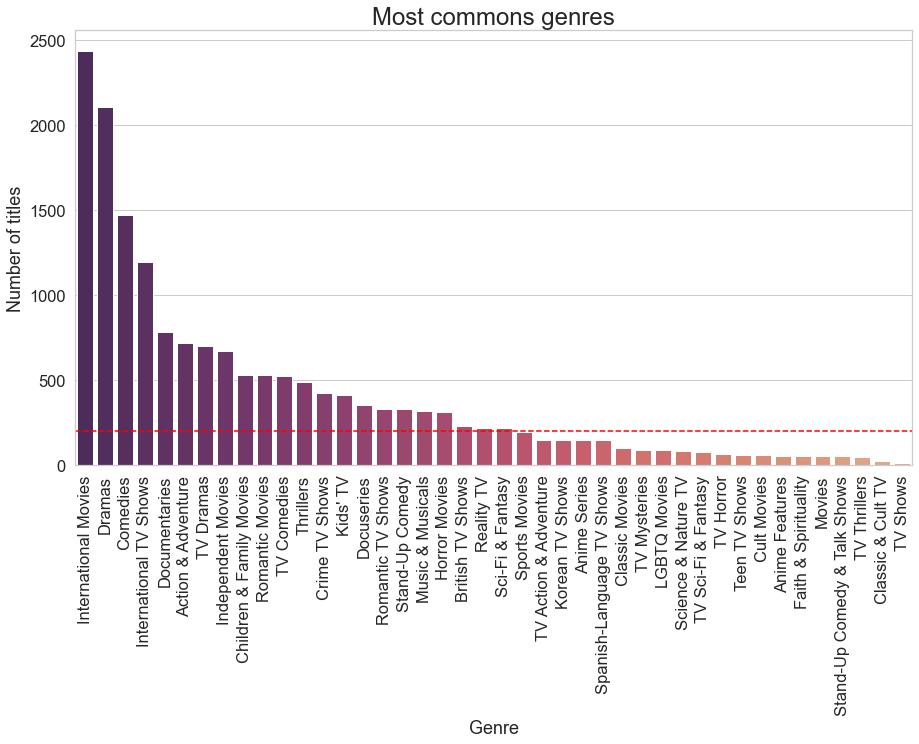

In [16]:
# Categories below a certain number of cases can reduce prediction accuracy
# Set threshold for minimum number of cases to be considered in analysis
threshold = 200

# Plot a histogram for genres
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
sns.set_style('whitegrid') 


pal = sns.color_palette("flare_r", len(genre_count))
rank = genre_count['count'].argsort().argsort()  

sns.barplot(genre_count['genre'], genre_count['count'], palette=np.array(pal[::-1])[rank])
plt.axhline(threshold, ls='--', c='red')
plt.title("Most commons genres", fontsize=24)
plt.ylabel('Number of titles', fontsize=18)
plt.xlabel('Genre', fontsize=18)
plt.xticks(rotation='vertical')

plt.show()

We can see several genres fall below the arbitrary threshold of 200. As a result I have made a executive decision to cluster these genres into a new genre called "Others". 

In [17]:
# Merge together genres below the threshhold into a new variable called 'Others'
main_genres = pd.DataFrame()
main_genres = genre_count[genre_count['count']>200]
final_genres = main_genres['genre'].values
final_genres = np.append(final_genres,'Others')
not_genre = []
netflix['Others'] = 0

for i in netflix.columns[1:]:
    if i not in final_genres:
        netflix['Others'][netflix[i] == 1] = 1
        not_genre.append(i)

netflix.drop(not_genre, axis=1, inplace=True)

<ipython-input-17-56f1016f5d44>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  netflix['Others'][netflix[i] == 1] = 1
<ipython-input-17-56f1016f5d44>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  netflix['Others'][netflix[i] == 1] = 1
<ipython-input-17-56f1016f5d44>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  netflix['Others'][netflix[i] == 1] = 1
<ipython-input-17-56f1016f5d44>:11: SettingWithCopyWarning: 
A value is tryi

In [18]:
# Recount the cases which contain each genre with the new 'Others' genre
most_common_genres = pd.DataFrame()
most_common_genres['genre'] = netflix.columns[1:]
most_common_genres['count'] = netflix.iloc[:,1:].sum().values
most_common_genres.sort_values(['count'], inplace=True, ascending=False)
most_common_genres.reset_index(inplace=True, drop=True)
most_common_genres.head()

,genre,count
0,International Movies,2437
1,Dramas,2106
2,Others,1544
3,Comedies,1471
4,International TV Shows,1199


Lets replot the original histogram with the new "Others" genre included. We do not need to include the threshold line this time as we know all genres have over 200 cases.

C:\Users\dance\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


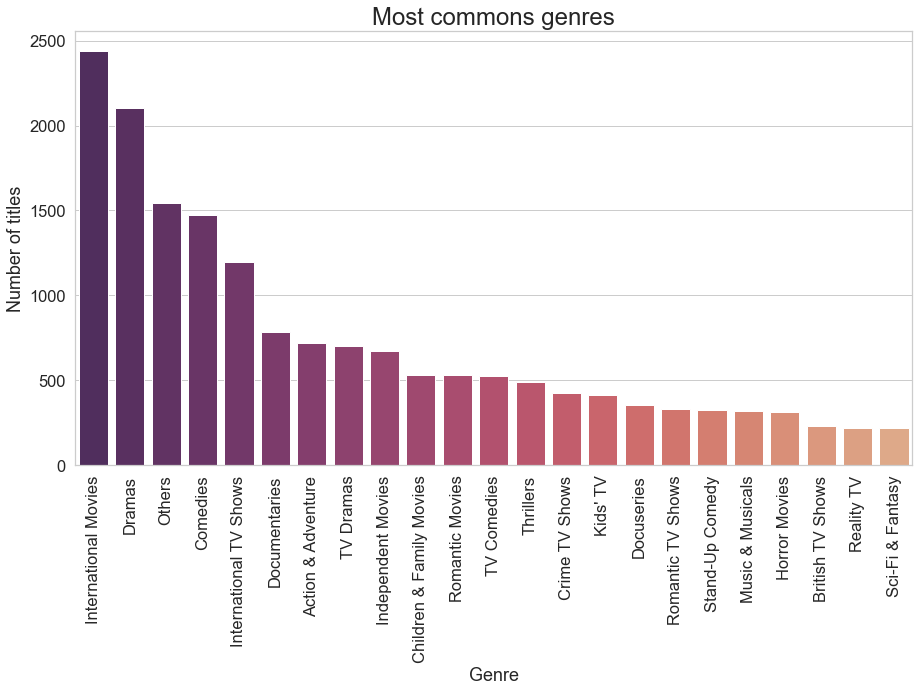

In [19]:
# Plot the new histogram for genres
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
sns.set_style('whitegrid') 


pal = sns.color_palette("flare_r", len(most_common_genres))
rank = most_common_genres['count'].argsort().argsort()  

sns.barplot(most_common_genres['genre'], most_common_genres['count'], palette=np.array(pal[::-1])[rank])
plt.title("Most commons genres", fontsize=24)
plt.ylabel('Number of titles', fontsize=18)
plt.xlabel('Genre', fontsize=18)
plt.xticks(rotation='vertical')

plt.show()

We can see that the most common genre is "International Movies" from the histogram.

#### Total amount of genres per title
Next counting the number of titles having multiple labels and calculating the word frequency can be helpful as well.

In [20]:
rowSums = netflix.iloc[:,1:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()

C:\Users\dance\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


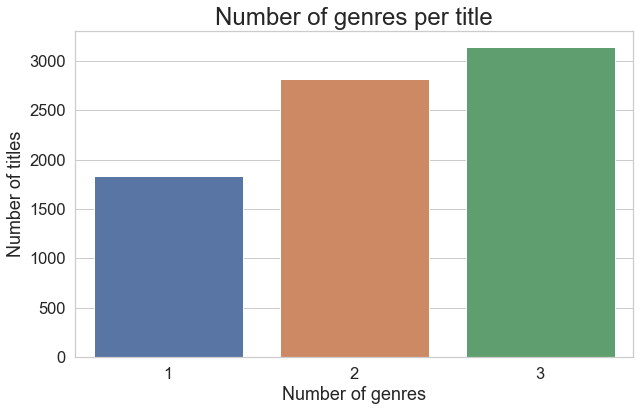

In [21]:
sns.set(font_scale = 1.5)
sns.set_style('whitegrid') 
plt.figure(figsize=(10,6))

sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Number of genres per title", fontsize=24)
plt.ylabel('Number of titles', fontsize=18)
plt.xlabel('Number of genres', fontsize=18)

plt.show()

This bar chart shows us the frequeny of genres. We can see most titles have 3 genres in total followed by 2 and the fewest amount of titles have only 1 genre.

#### Word frequency

Next we can look at the distribution of words for the description 

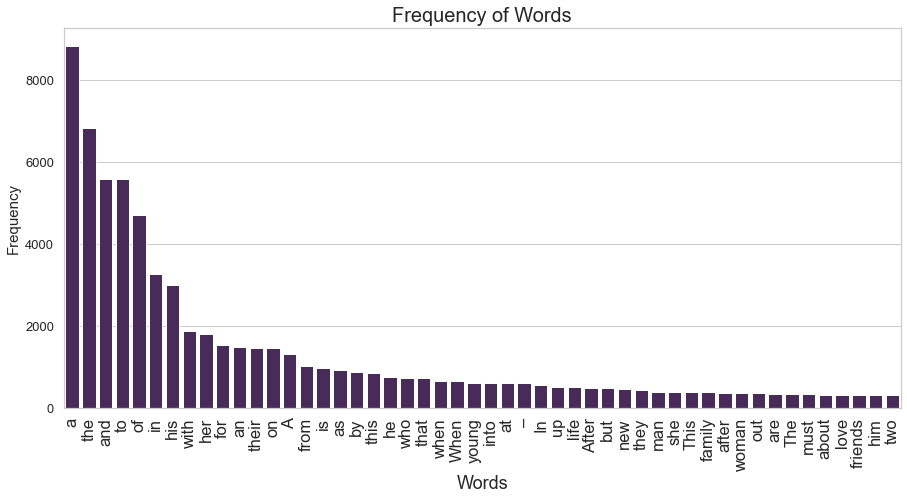

In [22]:
# count the number of occurances for each word
from collections import Counter 


num = 50
# create a counter of words in all descriptions combined
word_list = [word for description in netflix.description for word in description.split()]
word_count = Counter(word_list)

# create a dataframe from the counter
word_count_df = pd.DataFrame.from_dict(word_count.items(), orient='columns')
word_count_df.columns = ['word', 'count']
word_count_df = word_count_df.sort_values('count', ascending = False)

# plot a bar chart
plt.figure(figsize=(15,7))

pal = sns.color_palette("flare_r", len(word_count_df))
rank = word_count_df['count'].argsort().argsort()  

sns.barplot(x=word_count_df['word'][:num], y=word_count_df['count'][:num], palette=np.array(pal[::-1])[rank])
plt.title("Frequency of Words", fontsize=20)
plt.ylabel("Frequency", fontsize=15)
plt.xlabel('Words', fontsize=18)
plt.xticks(rotation='vertical')
plt.yticks(fontsize=13)

plt.show()

As expected, most of the top 30 most common words are stopwords. Some of the words are lowercase, while others are uppercase, which means the same word can often be counted as two separate words. For example, the graph shows two different bars for "a" and "A". Therefore, it is important to do some data processing for any furhter analysis.

Next we can look at the distribution of words for the description 

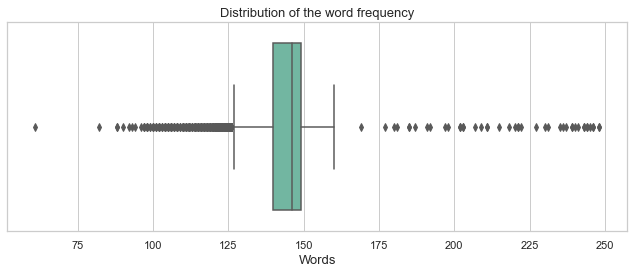

In [23]:
boxplot = netflix.copy()
boxplot['len'] = netflix.description.apply(lambda x: len(x))
sns.set(style="whitegrid",rc={"font.size":13,"axes.labelsize":13})

plt.figure(figsize=(9, 4))

ax = sns.boxplot(x='len', data=boxplot, orient="h", palette="Set2")
plt.ylabel('')
plt.xlabel('Words')
plt.title("Distribution of the word frequency", fontsize=13)
plt.tight_layout(h_pad=3)

The majority of the descriptions have about 150 words and we can see most titles have roughly 125 to 160 amount of words. Although we can also see there is several outliers which could suggest that this distribution is not reliable.

#### Wordcloud

The word cloud below shows the most frequent words in the description field.

In [24]:
# install the package
!conda install -c conda-forge wordcloud -y

Solving environment: ...working... done

# All requested packages already installed.



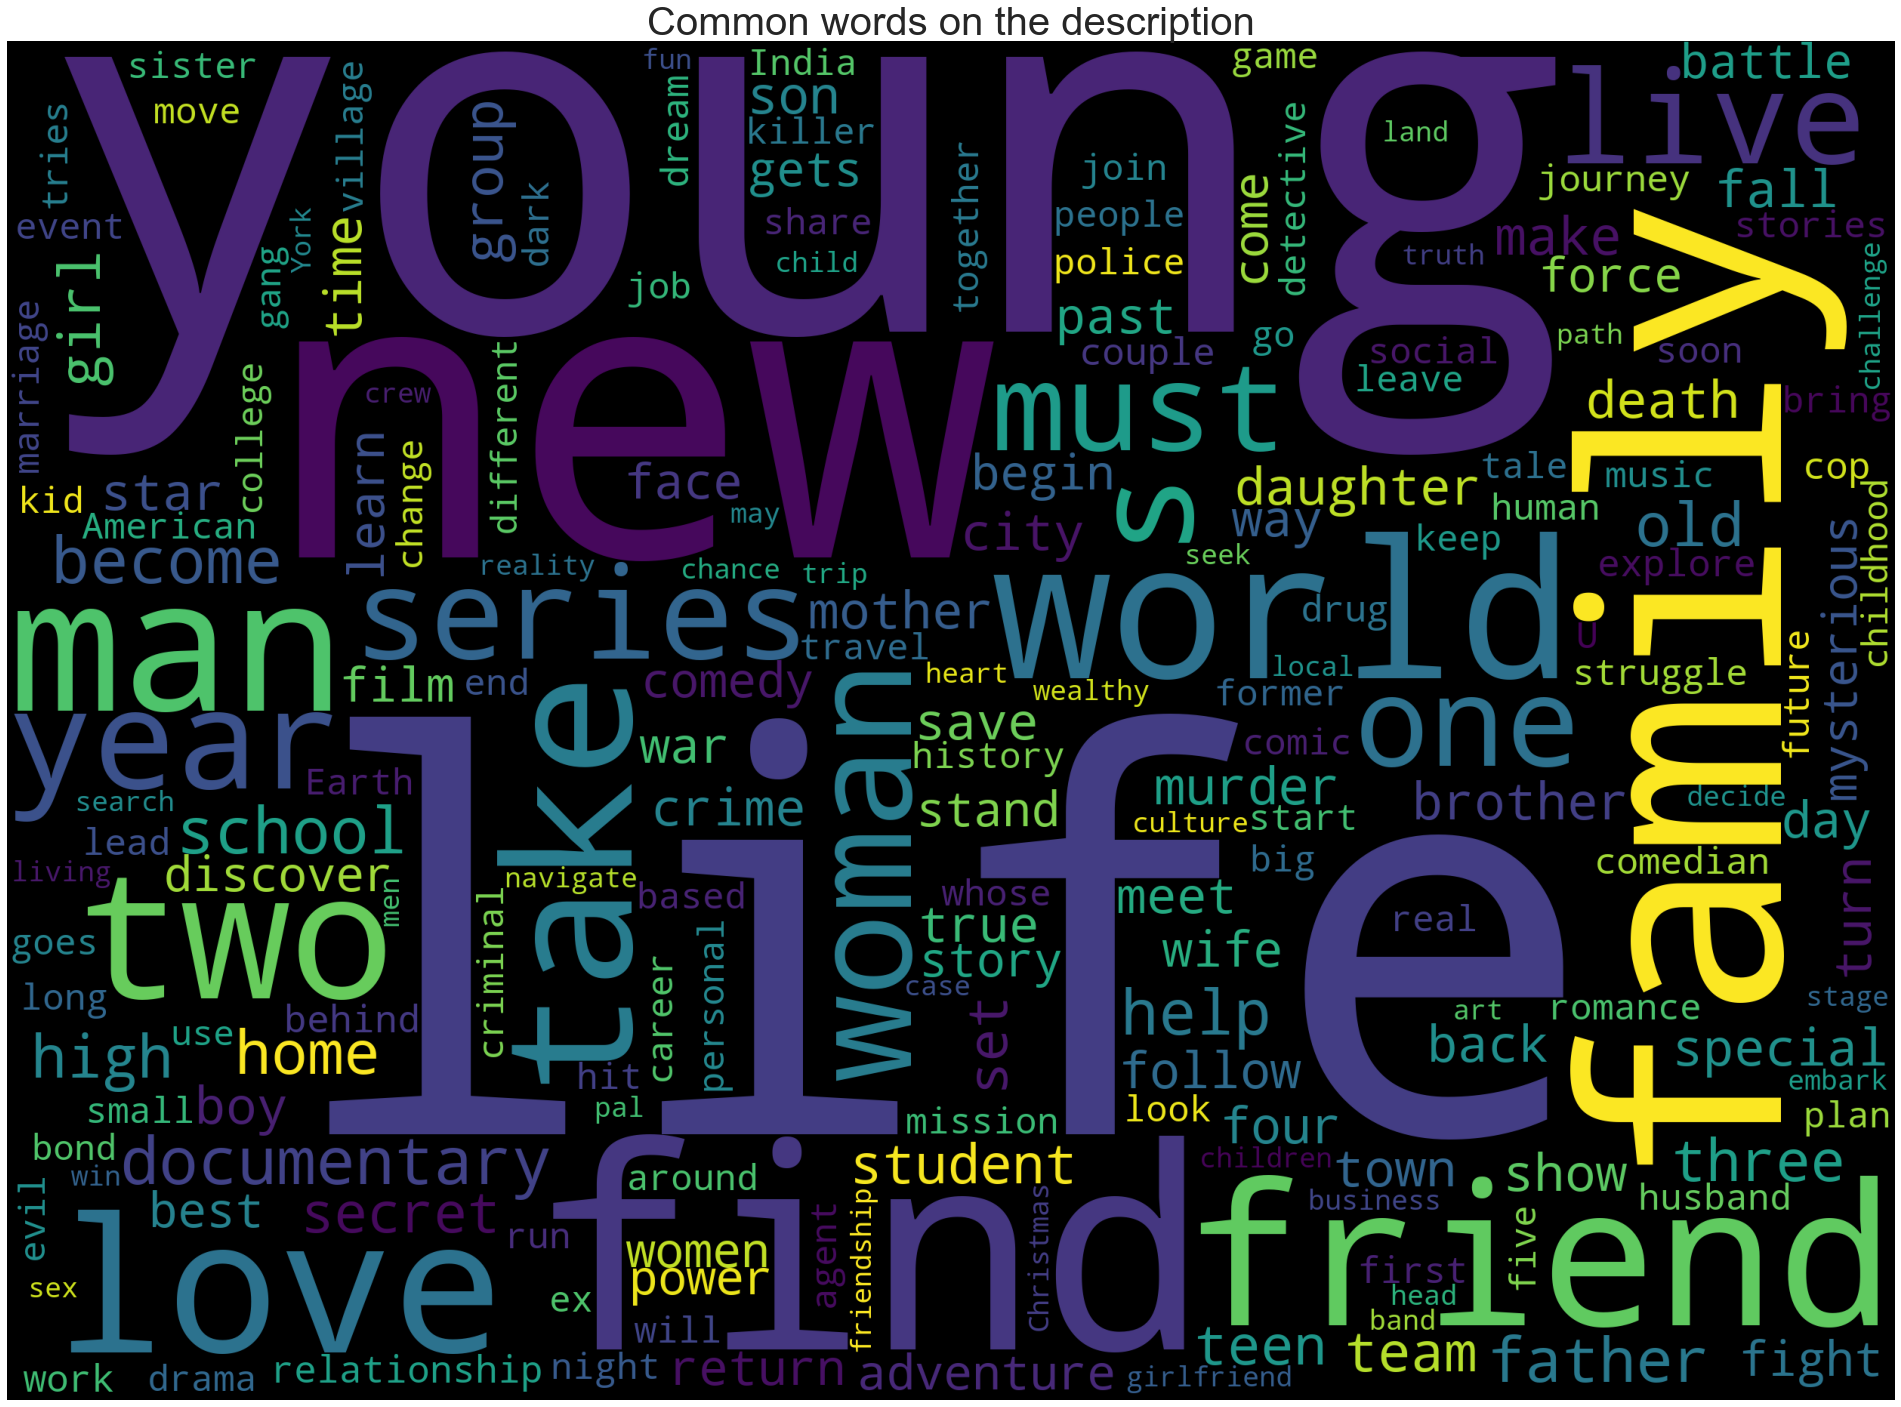

In [25]:
from wordcloud import WordCloud,STOPWORDS

plt.figure(figsize=(40,25))
text = netflix.description.values
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("Common words on the description",fontsize=40)
plt.imshow(cloud)

<h3> <font color="blue"> Preprocessing  </font> </h3>

It is necessary to prepare our 'description' variable in order to used as an input to our models. As we saw in the histogram for word frequency, currently lowercase and uppercase versions of the same word are considered different words. As a result it is necessary to normalise each description so that all words are lowercase. It is also important to remove the stopwords, as they do not add much meaning but can greatly increase the dimensionality. Similarly, any numeric characters can be removed. It is also important to remove any punctuation and expand any potential contractions. All of these can be achieved using the following functions.

### Normalisation

In [26]:
import nltk
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

In [27]:
def decontract(words):
    # specific
    words = re.sub(r"won't", "will not", words)
    words = re.sub(r"can\'t", "can not", words)

    # general
    words = re.sub(r"n\'t", " not", words)
    words = re.sub(r"\'re", " are", words)
    words = re.sub(r"\'s", " is", words)
    words = re.sub(r"\'d", " would", words)
    words = re.sub(r"\'ll", " will", words)
    words = re.sub(r"\'t", " not", words)
    words = re.sub(r"\'ve", " have", words)
    words = re.sub(r"\'m", " am", words)
    return words

def cleanPunc(words): 
    cleanedpunc = re.sub(r'[?|!|\'|"|#]',r'',words)
    cleanedpunc = re.sub(r'[.|,|)|(|\|/]',r' ',cleanedpunc)
    cleanedpunc = cleanedpunc.strip()
    cleanedpunc = cleanedpunc.replace("\n"," ")
    return cleanedpunc

def keepAlpha(words):
    alpha_sent = ""
    for word in words.split():
        alpha_word = re.sub('[^a-z A-Z]+', '', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

def removeStopWords(words):
    global re_stop_words
    return re_stop_words.sub("", words)

In [28]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

re_stop_words = re.compile(r"\b(" + "|".join(stopwords) + ")\\W", re.I)

In [29]:
# Run functions to normalise data
netflix['description'] = netflix['description'].str.lower()
netflix['description'] = netflix['description'].apply(decontract)
netflix['description'] = netflix['description'].apply(cleanPunc)
netflix['description'] = netflix['description'].apply(keepAlpha)
netflix['description'] = netflix['description'].apply(removeStopWords)

In [30]:
# We can have a look at what our 'description' column looks like now
netflix['description']

0       future elite inhabit island paradise far crowd...
1       devastating earthquake hits mexico city trappe...
2       army recruit found dead fellow soldiers forced...
3       postapocalyptic world ragdoll robots hide fear...
4       brilliant group students become cardcounting e...
                              ...                        
7782    lebanon civil war deprives zozo family left gr...
7783    scrappy poor boy worms way tycoon dysfunctiona...
7784    documentary south african rapper nasty c hits ...
7785    dessert wizard adriano zumbo looks next willy ...
7786    documentary delves mystique behind bluesrock t...
Name: description, Length: 7787, dtype: object

### Stemming

Stemmers remove morphological affixes from words, leaving only the word stem. It is a fast and simple technique but it can inadvertedly change the meaning of tokens. There are two popular stemmers available in nltk - Porter and Snowball.

Let's make a copy of the dataset for each stemmer to simplify any further experimentation.

In [31]:
# Copy to be used with PorterStemmer
netflix_porter = netflix.copy()

# Copy to be used with SnowballStemmer
netflix_snowball = netflix.copy()

In [32]:
# Import necessary packages
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

#### PorterStemmer

In [33]:
# Define the stemmer function to use the PorterStemmer
stemmerPorter = PorterStemmer()
def stemmingPorter(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmerPorter.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [34]:
netflix_porter['description'] = netflix_porter['description'].apply(stemmingPorter)

In [35]:
# Final form of our description column
netflix_porter['description']

0       futur elit inhabit island paradis far crowd sl...
1       devast earthquak hit mexico citi trap survivor...
2       armi recruit found dead fellow soldier forc co...
3       postapocalypt world ragdol robot hide fear dan...
4       brilliant group student becom cardcount expert...
                              ...                        
7782    lebanon civil war depriv zozo famili left grie...
7783    scrappi poor boy worm way tycoon dysfunct fami...
7784    documentari south african rapper nasti c hit s...
7785    dessert wizard adriano zumbo look next willi w...
7786    documentari delv mystiqu behind bluesrock trio...
Name: description, Length: 7787, dtype: object

#### SnowballStemmer

In [36]:
# Define the stemmer function to use the SnowballStemmer
stemmerSnowball = SnowballStemmer("english")
def stemmingSnowball(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmerSnowball.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [37]:
netflix_snowball['description'] = netflix_snowball['description'].apply(stemmingSnowball)

In [38]:
# Final form of our description column
netflix_snowball['description']

0       futur elit inhabit island paradis far crowd sl...
1       devast earthquak hit mexico citi trap survivor...
2       armi recruit found dead fellow soldier forc co...
3       postapocalypt world ragdol robot hide fear dan...
4       brilliant group student becom cardcount expert...
                              ...                        
7782    lebanon civil war depriv zozo famili left grie...
7783    scrappi poor boy worm way tycoon dysfunct fami...
7784    documentari south african rapper nasti c hit s...
7785    dessert wizard adriano zumbo look next willi w...
7786    documentari delv mystiqu behind bluesrock trio...
Name: description, Length: 7787, dtype: object

#### Comparisson

In [39]:
# create a 'vocab' of unique stemmed tokens for each 'manual' copy
manual_port_vocab = set([token for description in netflix_porter.description for token in description])
manual_snow_vocab = set([token for description in netflix_snowball.description for token in description])

# check lengths
print("Number of unique tokens produced by PortStemmer:", len(manual_port_vocab))
print("Number of unique tokens produced by SnowStemmer:", len(manual_snow_vocab))
#check differences
print("Differences in stemmed tokens:\n", manual_port_vocab.symmetric_difference(manual_snow_vocab))

Number of unique tokens produced by PortStemmer: 27
Number of unique tokens produced by SnowStemmer: 27
Differences in stemmed tokens:
 set()


We can see that there is no differences between the two stemmers so we can use either one without the other in our analysis.

In [40]:
netflix['description'] = netflix['description'].apply(stemmingSnowball)

#### Word Embedding (Tokenizer)

For the following models, the vectorization used was texts_to_sequences, which transforms the words in numbers, and the pad_sequences ensures all the vectors have the same length.

In [41]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [42]:
# Text_to_sequences
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(netflix['description'])
sequences = tokenizer.texts_to_sequences(netflix['description'])
x = pad_sequences(sequences, maxlen=200)

<h3> <font color="blue"> Models  </font> </h3>
I have decided to look at 5 different deep learning techniques. They are the following: Multi-Layered Perceptron, Recurrent Neural Network, Dense Neural Network, Convolutional Neural Network and Long short-term memory. The aim is to determine which deep learning technique best predicts for our data.

In [43]:
# Create a table to store accuracy results from training
columns=['Seed','MLP', 'RNN','DNN', 'CNN', 'LSTM']
results = pd.DataFrame(columns = columns)
results

,Seed,MLP,RNN,DNN,CNN,LSTM


In [44]:
# A model’s performance is assessed after running it with 5 different seeds to try to mitigate any bias.
seeds = [1, 43, 678, 90, 135]
results['Seed'] = seeds
results

,Seed,MLP,RNN,DNN,CNN,LSTM
0,1,NaN,NaN,NaN,NaN,NaN
1,43,NaN,NaN,NaN,NaN,NaN
2,678,NaN,NaN,NaN,NaN,NaN
3,90,NaN,NaN,NaN,NaN,NaN
4,135,NaN,NaN,NaN,NaN,NaN


In [45]:
# Define some variable values for analysis by splitting the data
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    netflix[netflix.columns[1:]], 
                                                    test_size=0.3, 
                                                    random_state=seeds[4])

num_classes = y_train.shape[1]
max_words = len(tokenizer.word_index) + 1
maxlen = 200

<h3> <font color="blue"> Deep Learning Models  </font> </h3>

Text classification has benefited from the deep learning architectures’ trend due to their potential to reach high accuracy. For deep learning I have decided to use the Tensorflow library. This is due to its potential to reach a high accuracy.

Class weights were calculated to address the imbalance problem in the categories.

In [46]:
# Calculate class weights for neural network analysis
most_common_genres['class_weight'] = len(most_common_genres) / most_common_genres['count']
class_weight = {}
for index, label in enumerate(final_genres):
    class_weight[index] = most_common_genres[most_common_genres['genre'] == final_genres]['class_weight'].values[0]
    
most_common_genres.head()

,genre,count,class_weight
0,International Movies,2437,0.009438
1,Dramas,2106,0.010921
2,Others,1544,0.014896
3,Comedies,1471,0.015636
4,International TV Shows,1199,0.019183


#### MLP

Multi-layer perceptron is a type of network where multiple layers of a group of perceptron are stacked together to make a model.

In [47]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import tensorflow as tf

model = Sequential()
model.add(Dense(200, activation='sigmoid', kernel_initializer='he_normal', input_shape=(maxlen,)))
model.add(Dense(100, activation='sigmoid', kernel_initializer='he_normal'))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(optimizer=Adam(0.015), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])



for i in range(5):
   # Split the data over 5 seeds to remove bias
    X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    netflix[netflix.columns[1:]], 
                                                    test_size=0.3, 
                                                    random_state=seeds[i])
    history = model.fit(X_train, y_train,
                    class_weight=class_weight,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.3)
    
    mlp_model = model
    metrics = mlp_model.evaluate(X_test, y_test)
    print("{}: {}".format(mlp_model.metrics_names[1], metrics[1]))
    results.loc[i,'MLP'] = metrics[1]

Epoch 1/30
120/120 [==============================] - 2s 12ms/step - loss: 0.0030 - auc: 0.6728 - val_loss: 0.2874 - val_auc: 0.7106
Epoch 2/30
120/120 [==============================] - 0s 2ms/step - loss: 0.0027 - auc: 0.7030 - val_loss: 0.2893 - val_auc: 0.7014
Epoch 3/30
120/120 [==============================] - 0s 2ms/step - loss: 0.0027 - auc: 0.7071 - val_loss: 0.2882 - val_auc: 0.7092
Epoch 4/30
120/120 [==============================] - 0s 2ms/step - loss: 0.0027 - auc: 0.6983 - val_loss: 0.2885 - val_auc: 0.7049
Epoch 5/30
120/120 [==============================] - 0s 2ms/step - loss: 0.0027 - auc: 0.7013 - val_loss: 0.2890 - val_auc: 0.7013
Epoch 6/30
120/120 [==============================] - 0s 2ms/step - loss: 0.0027 - auc: 0.7022 - val_loss: 0.2923 - val_auc: 0.6863
Epoch 7/30
120/120 [==============================] - 0s 2ms/step - loss: 0.0027 - auc: 0.6955 - val_loss: 0.2902 - val_auc: 0.7040
Epoch 8/30
120/120 [==============================] - 0s 2ms/step - loss: 0

Epoch 1/30
120/120 [==============================] - 0s 3ms/step - loss: 0.0027 - auc: 0.7048 - val_loss: 0.2864 - val_auc: 0.7124
Epoch 2/30
120/120 [==============================] - 0s 2ms/step - loss: 0.0027 - auc: 0.7040 - val_loss: 0.2858 - val_auc: 0.7215
Epoch 3/30
120/120 [==============================] - 0s 2ms/step - loss: 0.0027 - auc: 0.7041 - val_loss: 0.2853 - val_auc: 0.7205
Epoch 4/30
120/120 [==============================] - 0s 2ms/step - loss: 0.0027 - auc: 0.7053 - val_loss: 0.2868 - val_auc: 0.7142
Epoch 5/30
120/120 [==============================] - 0s 2ms/step - loss: 0.0027 - auc: 0.7062 - val_loss: 0.2907 - val_auc: 0.7057
Epoch 6/30
120/120 [==============================] - 0s 2ms/step - loss: 0.0027 - auc: 0.7042 - val_loss: 0.2852 - val_auc: 0.7209
Epoch 7/30
120/120 [==============================] - 0s 2ms/step - loss: 0.0027 - auc: 0.7056 - val_loss: 0.2854 - val_auc: 0.7177
Epoch 8/30
120/120 [==============================] - 0s 2ms/step - loss: 0.

In [48]:
results

,Seed,MLP,RNN,DNN,CNN,LSTM
0,1,0.710653,NaN,NaN,NaN,NaN
1,43,0.705861,NaN,NaN,NaN,NaN
2,678,0.700746,NaN,NaN,NaN,NaN
3,90,0.704623,NaN,NaN,NaN,NaN
4,135,0.715575,NaN,NaN,NaN,NaN


#### RNN
A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

In [49]:
from keras.layers import SimpleRNN
from keras.models import load_model

model = Sequential()
model.add(Embedding(max_words, 20, input_length=maxlen)) 
model.add(SimpleRNN(32))               
model.add(Dense(23, activation='sigmoid'))
model.summary()

model.compile(optimizer=Adam(0.015), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])


for i in range(5):
   # Split the data over 5 seeds to remove bias
    X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    netflix[netflix.columns[1:]], 
                                                    test_size=0.3, 
                                                    random_state=seeds[i])
    history = model.fit(X_train, y_train,
                    class_weight=class_weight,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.3)
    
    rnn_model = model
    metrics = rnn_model.evaluate(X_test, y_test)
    print("{}: {}".format(rnn_model.metrics_names[1], metrics[1]))
    results.loc[i,'RNN'] = metrics[1]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 20)           277520    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                1696      
_________________________________________________________________
dense_3 (Dense)              (None, 23)                759       
Total params: 279,975
Trainable params: 279,975
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
120/120 [==============================] - 4s 24ms/step - loss: 0.0034 - auc_1: 0.6493 - val_loss: 0.2851 - val_auc_1: 0.7173
Epoch 2/30
120/120 [==============================] - 2s 21ms/step - loss: 0.0027 - auc_1: 0.7391 - val_loss: 0.3094 - val_auc_1: 0.6962
Epoch 3/30
120/120 [==============================] - 3s 22ms/step - loss: 0.0027 - auc_1: 0.7155 - val_

Epoch 22/30
120/120 [==============================] - 3s 23ms/step - loss: 0.0018 - auc_1: 0.8986 - val_loss: 0.3007 - val_auc_1: 0.7674
Epoch 23/30
120/120 [==============================] - 3s 23ms/step - loss: 0.0018 - auc_1: 0.8996 - val_loss: 0.3029 - val_auc_1: 0.7712
Epoch 24/30
120/120 [==============================] - 2s 21ms/step - loss: 0.0018 - auc_1: 0.9040 - val_loss: 0.3094 - val_auc_1: 0.7608
Epoch 25/30
120/120 [==============================] - 3s 21ms/step - loss: 0.0019 - auc_1: 0.8980 - val_loss: 0.3059 - val_auc_1: 0.7689
Epoch 26/30
120/120 [==============================] - 3s 23ms/step - loss: 0.0020 - auc_1: 0.8838 - val_loss: 0.3084 - val_auc_1: 0.7566
Epoch 27/30
120/120 [==============================] - 3s 22ms/step - loss: 0.0020 - auc_1: 0.8810 - val_loss: 0.3063 - val_auc_1: 0.7606
Epoch 28/30
120/120 [==============================] - 3s 26ms/step - loss: 0.0019 - auc_1: 0.8939 - val_loss: 0.3072 - val_auc_1: 0.7639
Epoch 29/30
120/120 [=============

In [50]:
results

,Seed,MLP,RNN,DNN,CNN,LSTM
0,1,0.710653,0.640033,NaN,NaN,NaN
1,43,0.705861,0.712454,NaN,NaN,NaN
2,678,0.700746,0.744319,NaN,NaN,NaN
3,90,0.704623,0.760277,NaN,NaN,NaN
4,135,0.715575,0.781727,NaN,NaN,NaN


#### DNN

We started with a simple model which only consists of an embedding layer, a dropout layer to reduce the size and prevent overfitting, a max-pooling layer, and one dense layer with a sigmoid activation to produce probabilities for each of the categories that we want to predict.

In [51]:
from keras.layers import GlobalMaxPool1D
from keras.models import load_model

model = Sequential()
model.add(Embedding(max_words, 20, input_length=maxlen))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes, activation='sigmoid'))
model.summary()

model.compile(optimizer=Adam(0.015), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])


for i in range(5):
   # Split the data over 5 seeds to remove bias
    X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    netflix[netflix.columns[1:]], 
                                                    test_size=0.3, 
                                                    random_state=seeds[i])
    history = model.fit(X_train, y_train,
                    class_weight=class_weight,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.3)
    
    dnn_model = model
    metrics = dnn_model.evaluate(X_test, y_test)
    print("{}: {}".format(dnn_model.metrics_names[1], metrics[1]))
    results.loc[i,'DNN'] = metrics[1]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 20)           277520    
_________________________________________________________________
global_max_pooling1d (Global (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 23)                483       
Total params: 278,003
Trainable params: 278,003
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
120/120 [==============================] - 1s 7ms/step - loss: 0.0040 - auc_2: 0.5776 - val_loss: 0.2788 - val_auc_2: 0.7358
Epoch 2/30
120/120 [==============================] - 1s 5ms/step - loss: 0.0025 - auc_2: 0.7608 - val_loss: 0.2632 - val_auc_2: 0.7866
Epoch 3/30
120/120 [==============================] - 1s 5ms/step - loss: 0.0023 - auc_2: 0.8296 - val_los

Epoch 24/30
120/120 [==============================] - 1s 4ms/step - loss: 8.0203e-04 - auc_2: 0.9834 - val_loss: 0.4831 - val_auc_2: 0.7847
Epoch 25/30
120/120 [==============================] - 1s 5ms/step - loss: 7.8227e-04 - auc_2: 0.9844 - val_loss: 0.4952 - val_auc_2: 0.7806
Epoch 26/30
120/120 [==============================] - 1s 4ms/step - loss: 7.6841e-04 - auc_2: 0.9845 - val_loss: 0.5039 - val_auc_2: 0.7803
Epoch 27/30
120/120 [==============================] - 1s 5ms/step - loss: 7.4946e-04 - auc_2: 0.9856 - val_loss: 0.5140 - val_auc_2: 0.7751
Epoch 28/30
120/120 [==============================] - 1s 5ms/step - loss: 7.3422e-04 - auc_2: 0.9860 - val_loss: 0.5244 - val_auc_2: 0.7753
Epoch 29/30
120/120 [==============================] - 1s 4ms/step - loss: 7.1439e-04 - auc_2: 0.9867 - val_loss: 0.5382 - val_auc_2: 0.7722
Epoch 30/30
74/74 [==============================] - 0s 1ms/step - loss: 0.5368 - auc_2: 0.7753
auc_2: 0.7753247022628784
Epoch 1/30
120/120 [============

In [52]:
results

,Seed,MLP,RNN,DNN,CNN,LSTM
0,1,0.710653,0.640033,0.688464,NaN,NaN
1,43,0.705861,0.712454,0.775325,NaN,NaN
2,678,0.700746,0.744319,0.794657,NaN,NaN
3,90,0.704623,0.760277,0.814957,NaN,NaN
4,135,0.715575,0.781727,0.81973,NaN,NaN


#### CNN

Convolutional Neural Networks recognize local patterns in a sequence by processing multiple words at the same time, and 1D convolutional networks are suitable for text processing tasks. In this case, the convolutional layer uses a window size of 3 and learns word sequences that can later be recognized in any position of a text.

In [53]:
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.models import load_model

filter_length = 300

model = Sequential()
model.add(Embedding(max_words, 20, input_length=maxlen))
model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])


for i in range(5):
   # Split the data over 5 seeds to remove bias
    X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    netflix[netflix.columns[1:]], 
                                                    test_size=0.3, 
                                                    random_state=seeds[i])
    history = model.fit(X_train, y_train,
                    class_weight=class_weight,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.3)
    
    cnn_model = model
    metrics = cnn_model.evaluate(X_test, y_test)
    print("{}: {}".format(cnn_model.metrics_names[1], metrics[1]))
    results.loc[i,'CNN'] = metrics[1]

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 20)           277520    
_________________________________________________________________
conv1d (Conv1D)              (None, 198, 300)          18300     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 23)                6923      
_________________________________________________________________
activation (Activation)      (None, 23)                0         
Total params: 302,743
Trainable params: 302,743
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
120/120 [==============================] - 3s 20ms/step - loss: 0.0050 - auc_3: 0.5295 - val_loss: 0.28

120/120 [==============================] - 2s 21ms/step - loss: 1.6299e-05 - auc_3: 1.0000 - val_loss: 0.1793 - val_auc_3: 0.9404
Epoch 18/30
120/120 [==============================] - 3s 25ms/step - loss: 1.5807e-05 - auc_3: 1.0000 - val_loss: 0.1814 - val_auc_3: 0.9406
Epoch 19/30
120/120 [==============================] - 3s 26ms/step - loss: 1.4622e-05 - auc_3: 1.0000 - val_loss: 0.1838 - val_auc_3: 0.9400
Epoch 20/30
120/120 [==============================] - 3s 22ms/step - loss: 1.2846e-05 - auc_3: 1.0000 - val_loss: 0.1859 - val_auc_3: 0.9388
Epoch 21/30
120/120 [==============================] - 3s 22ms/step - loss: 1.2466e-05 - auc_3: 1.0000 - val_loss: 0.1879 - val_auc_3: 0.9390
Epoch 22/30
120/120 [==============================] - 3s 22ms/step - loss: 1.1100e-05 - auc_3: 1.0000 - val_loss: 0.1909 - val_auc_3: 0.9378
Epoch 23/30
120/120 [==============================] - 3s 21ms/step - loss: 1.1225e-05 - auc_3: 1.0000 - val_loss: 0.1935 - val_auc_3: 0.9367
Epoch 24/30
120/12

In [54]:
results

,Seed,MLP,RNN,DNN,CNN,LSTM
0,1,0.710653,0.640033,0.688464,0.697305,NaN
1,43,0.705861,0.712454,0.775325,0.826051,NaN
2,678,0.700746,0.744319,0.794657,0.890346,NaN
3,90,0.704623,0.760277,0.814957,0.934336,NaN
4,135,0.715575,0.781727,0.81973,0.957276,NaN


#### LSTM

In this model, we will use GloVe word embedding to convert text inputs to their numeric counterparts, which is a different approach because this is a pre-trained layer. The model will have one input layer, one embedding layer, one LSTM layer with 128 neurons, and one output layer with 23 neurons (the number of targets.)

In [55]:
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.models import load_model

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((max_words, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [56]:
from keras.layers import Input
from keras.layers import Flatten, LSTM
from keras.models import Model

deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(max_words, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(num_classes, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()])


for i in range(5):
   # Split the data over 5 seeds to remove bias
    X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    netflix[netflix.columns[1:]], 
                                                    test_size=0.3, 
                                                    random_state=seeds[i])
    history = model.fit(X_train, y_train,
                    class_weight=class_weight,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.3)
    
    lstm_model = model
    metrics = lstm_model.evaluate(X_test, y_test)
    print("{}: {}".format(lstm_model.metrics_names[1], metrics[1]))
    results.loc[i,'LSTM'] = metrics[1]
    

Epoch 1/30
120/120 [==============================] - 14s 102ms/step - loss: 0.0039 - auc_4: 0.5872 - val_loss: 0.2842 - val_auc_4: 0.7206
Epoch 2/30
120/120 [==============================] - 13s 110ms/step - loss: 0.0027 - auc_4: 0.7219 - val_loss: 0.2796 - val_auc_4: 0.7387
Epoch 3/30
120/120 [==============================] - 13s 109ms/step - loss: 0.0026 - auc_4: 0.7414 - val_loss: 0.2731 - val_auc_4: 0.7628
Epoch 4/30
120/120 [==============================] - 14s 121ms/step - loss: 0.0025 - auc_4: 0.7754 - val_loss: 0.2647 - val_auc_4: 0.7898
Epoch 5/30
120/120 [==============================] - 13s 105ms/step - loss: 0.0024 - auc_4: 0.7971 - val_loss: 0.2604 - val_auc_4: 0.7956
Epoch 6/30
120/120 [==============================] - 13s 112ms/step - loss: 0.0024 - auc_4: 0.8119 - val_loss: 0.2565 - val_auc_4: 0.8053
Epoch 7/30
120/120 [==============================] - 14s 113ms/step - loss: 0.0023 - auc_4: 0.8257 - val_loss: 0.2565 - val_auc_4: 0.8051
Epoch 8/30
120/120 [=======

Epoch 24/30
120/120 [==============================] - 14s 118ms/step - loss: 1.6972e-04 - auc_4: 0.9993 - val_loss: 0.2708 - val_auc_4: 0.8942
Epoch 25/30
120/120 [==============================] - 13s 107ms/step - loss: 3.2819e-04 - auc_4: 0.9969 - val_loss: 0.2673 - val_auc_4: 0.8942
Epoch 26/30
120/120 [==============================] - 14s 116ms/step - loss: 2.0546e-04 - auc_4: 0.9990 - val_loss: 0.2710 - val_auc_4: 0.8906
Epoch 27/30
120/120 [==============================] - 13s 110ms/step - loss: 9.8581e-05 - auc_4: 0.9999 - val_loss: 0.2760 - val_auc_4: 0.8882
Epoch 28/30
120/120 [==============================] - 15s 123ms/step - loss: 6.0622e-05 - auc_4: 1.0000 - val_loss: 0.2810 - val_auc_4: 0.8900
Epoch 29/30
120/120 [==============================] - 13s 108ms/step - loss: 4.6036e-05 - auc_4: 1.0000 - val_loss: 0.2859 - val_auc_4: 0.8858
Epoch 30/30
74/74 [==============================] - 3s 36ms/step - loss: 0.2823 - auc_4: 0.8871
auc_4: 0.8870886564254761
Epoch 1/30
12

In [57]:
results

,Seed,MLP,RNN,DNN,CNN,LSTM
0,1,0.710653,0.640033,0.688464,0.697305,0.799063
1,43,0.705861,0.712454,0.775325,0.826051,0.800004
2,678,0.700746,0.744319,0.794657,0.890346,0.845279
3,90,0.704623,0.760277,0.814957,0.934336,0.887089
4,135,0.715575,0.781727,0.81973,0.957276,0.920845


<h3> <font color="blue"> Evaluation  </font> </h3>

The evaluation metric to measure the performance of the models is the AUC measure, which stands for “Area Under the ROC Curve.” A ROC curve is a graph showing the performance of a classification model at all classification thresholds.

 
![title](https://miro.medium.com/max/500/1*mLZhWjBWtahuVaj9rqyh-A.png)

This curve plots two parameters:
True Positive Rate,
TPR = TP/(TP+FN),
False Positive Rate,
FPR = FP/(FP +TN),

In [59]:
def highlight_max(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [60]:
def highlight_min(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [61]:
results.iloc[:,1:6].style.apply(highlight_min, color='red', axis=None).apply(highlight_max, color='lightgreen', axis=None)

,MLP,RNN,DNN,CNN,LSTM
0,0.710653,0.640033,0.688464,0.697305,0.799063
1,0.705861,0.712454,0.775325,0.826051,0.800004
2,0.700746,0.744319,0.794657,0.890346,0.845279
3,0.704623,0.760277,0.814957,0.934336,0.887089
4,0.715575,0.781727,0.819730,0.957276,0.920845


In [62]:
from matplotlib.colors import LinearSegmentedColormap

#cm = sns.light_palette("green", as_cmap=True)
cm = LinearSegmentedColormap.from_list(
    name='test', 
    #colors=['red','white','green','white','red']
    colors=['tomato','orange','white','lightgreen','green']
)

t = results.iloc[:,1:6].apply(pd.to_numeric).style.background_gradient(cmap=cm)
t

,MLP,RNN,DNN,CNN,LSTM
0,0.710653,0.640033,0.688464,0.697305,0.799063
1,0.705861,0.712454,0.775325,0.826051,0.800004
2,0.700746,0.744319,0.794657,0.890346,0.845279
3,0.704623,0.760277,0.814957,0.934336,0.887089
4,0.715575,0.781727,0.819730,0.957276,0.920845


In [65]:
resultsmean = results.iloc[:, 1:6].mean()
resultsmean

MLP     0.707492
RNN     0.727762
DNN     0.778627
CNN     0.861063
LSTM    0.850456
dtype: float64

In conclusion, based on the benchmark, the Convolutional Neural Network showed the best AUC score with an overall mean value of 0.86, but the difference is minimal among each of the models. MLP, RNN and DNN showed considerably lower results than CNN and LSTM but are still suitable for this problem.

In [70]:
--allow-chromium-download

NameError: name 'allow' is not defined